### Plot the density ot MyShake reporting in some region. To do this, we'll need to design a grid and color each cell by the number of users within it

Design a grid and then figure out what phones are inside each cell. This will be needed in the noise analysis

In the Inbal paper, they group the users intp 4km sq cells and then stack the spectral amplitudes in each cell to make a noise model. We are probably going to need a larger grid cell, but since we can record when we want, we potientally have a very large data source. 

We first need to create a fast way to access the users cell by cell. The data for these users can then be found and processed 


In [109]:
import numpy as np
import pandas as pd
import geopy.distance
import utm
import matplotlib.pyplot as plt
import glob

In [231]:
region_code = 'LA'
regions = {'LA':[33,34.5,-118.7,-117.2]}

#Set up the coordinates of the region we wish to investiage
region = regions[region_code]
lat_min = region[0]
lat_max = region[1]
lon_min = region[2]
lon_max = region[3]

In [232]:
#lower left 
x1,y1,z1,u = utm.from_latlon(lat_min,lon_min)
#upper left 
x2,y2,z2,u = utm.from_latlon(lat_max,lon_min)
#upper right 
x3,y3,z3,u = utm.from_latlon(lat_max,lon_max)
#lower right
x4,y4,z4,u = utm.from_latlon(lat_min,lon_max)

#Distance along width (latitude)
Wd = geopy.distance.vincenty((lat_min,lon_min),(lat_max,lon_min)).m
#Distance along length (longitude)
Ld = geopy.distance.vincenty((lat_min,lon_min),(lat_min,lon_max)).m

z1,z2,z3,z4


(11, 11, 11, 11)

In [233]:
#Direction along width (latitude)
theta = np.arctan((y2-y1)/(x2-x1))
#Direction along length (longitude)
phi = np.arctan((y4-y1)/(x4-x1))

Open the files that contain information about which phones triggered and load their data. For every grid cell we're going to color by the number of phones inside

In [234]:
did_trigger = glob.glob('Devices_triggered*')
dfs = []
for infile in did_trigger[:2]:
    tmp = pd.read_csv(infile,index_col=0)
    dfs.append(tmp)

all_triggers = pd.concat(dfs)
print(len(all_triggers))

139


In [235]:
all_triggers.head()

,deviceId,triggerTimer,latitude,longitude,accuracy,altitude,triggerFrom
0,71adf5de-e1ce-344e-b115-488778bf2500,2018-09-08 04:30:17.836,34.403006,-118.547332,6.432000,348.758789,6
1,e2cccb36-2617-3dde-b8c0-d920792377eb,2018-09-08 04:30:17.871,34.259554,-118.519162,17.152000,278.339966,6
2,bfeda025-5028-339a-a90b-95b525dbc441,2018-09-08 04:30:17.943,34.449757,-118.680361,16.080000,429.000000,6
3,7beb637f-2166-3c24-96df-0b3aa00189a7,2018-09-08 04:30:17.950,34.051730,-118.446258,19.296001,29.000000,6
4,a4825018-a986-3377-97cb-0a02ce62ac7c,2018-09-08 04:30:17.979,33.971549,-118.352362,20.525000,0.000000,6


As a test of how long this might take, we're going to produce a map showing the density of all triggers since 01.01.2016 to 01.09.2018.
To do this we must load this large data file containing the trigger metadata

In [236]:
triggers_all = "/Users/rmartinshort/Documents/Berkeley/MyShake_project/Triggering_stats/trigger_databases/Devices_triggered_all_since_2016.csv"
all_triggers = pd.read_csv(triggers_all,index_col=0)

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


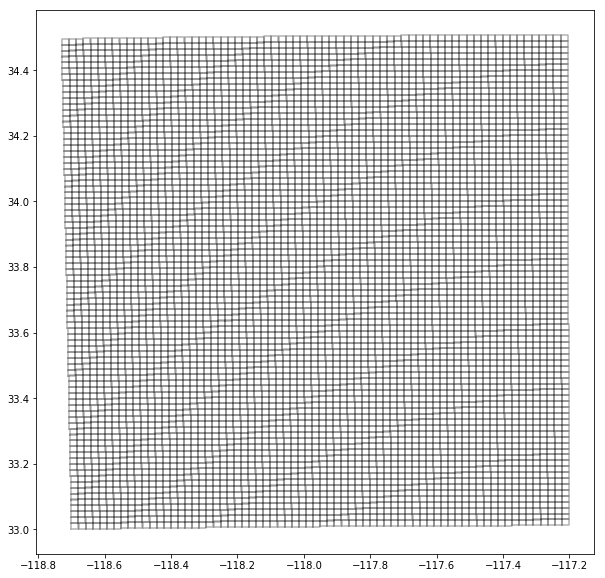

In [259]:
#Generate grid cells at nm spacing along the distances
#Note that the UTM coordinates are in meters
n_x = 2000
n_y = 2000
grid_points = []

lx = len(np.arange(n_x,Ld,n_x))
ly = len(np.arange(n_y,Wd,n_y))

#Fill this grid with the number of phone users in each cell
image_grid = np.zeros([ly,lx])

fig = plt.figure(figsize=(10,10))
i=0
for y_step in np.arange(n_y,Wd,n_y):
    y_step_dir = y_step*np.sin(theta)
    
    #Generate upper and lower bound for y
    y_new = y1 + y_step_dir
    y_old = y_new - n_y 
    j = 0
    for x_step in np.arange(n_x,Ld,n_x):
        x_step_dir = x_step*np.cos(phi)
        
        #Generate upper and lower bound for y
        x_new = x1 + x_step_dir
        x_old = x_new - n_x
        
        #Area of the grid cell in km^2
        area = (abs(y_new-y_old)*abs(x_new-x_old))/1e6
        
        #append lower left and upper right coordinates of each grid 
        #cell to this list. We will use these later to select the 
        #users in each cell
        
        (old_lat,old_lon) = utm.to_latlon(x_old,y_old,z1,u)
        (new_lat,new_lon) = utm.to_latlon(x_new,y_new,z1,u)
        
        #Extract just the users that lie within the grid cell of interest
        
        users_between = all_triggers[(all_triggers['latitude'] >= old_lat) & (all_triggers['latitude'] <= new_lat) & 
                                    (all_triggers['longitude'] >= old_lon) & (all_triggers['longitude'] <= new_lon)]
        
        number_of_users = len(users_between)
        if number_of_users == 0:
            image_grid[i,j] = np.nan
        else:
            image_grid[i,j] = number_of_users
            
        #This is going to plot the grid of points
        
        plt.plot([old_lon,new_lon,new_lon,old_lon,old_lon],[old_lat,old_lat,new_lat,new_lat,old_lat],
                 'k-',alpha=0.3)
        
        #For each cell we now have a set of users and data file locations (if we use the full data frame). We can then easily access 
        #the data on a cell-by cell basis and do the noise analysis on it
        
        grid_points.append([(old_lon,old_lat),(new_lon,old_lat),(new_lon,new_lat),(old_lon,new_lat),area,number_of_users])
        j += 1
    i+= 1
        
        
        

nan


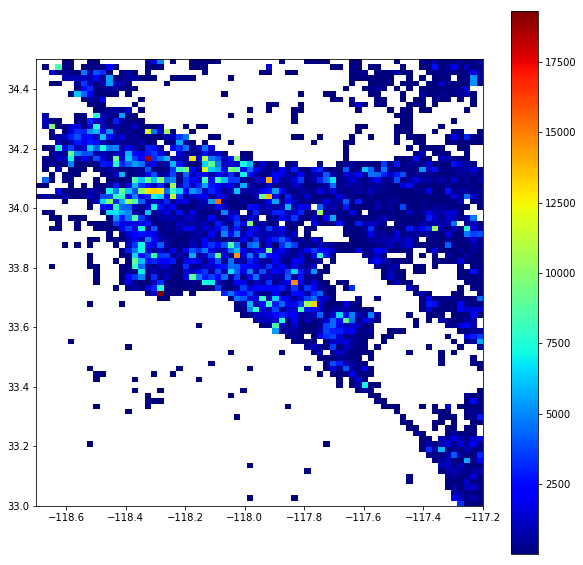

In [256]:
print(np.sum(image_grid))
plt.figure(figsize=(10,10))
plt.imshow(image_grid,extent=(lon_min,lon_max,lat_max,lat_min),cmap='jet',aspect='equal')
plt.gca().invert_yaxis()
plt.colorbar()

In [49]:
y3

3817615.3991421526

In [50]:
y4

3651304.703776421

In [51]:
y1

3652570.391255742

#### Plot this on top of an actual map

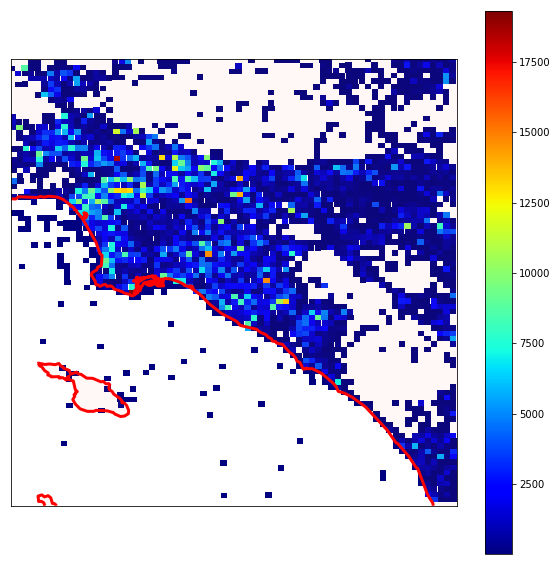

In [258]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
plt.rcParams['image.cmap'] = 'jet'

plt.figure(figsize=(10,10))
map = Basemap(llcrnrlon=-118.7, llcrnrlat=33., urcrnrlon=-117.2, urcrnrlat=34.5, 
              lat_0=33.75, lon_0=-118, resolution = 'h')

#map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines(linewidth=3,color='red')

patches = []
colors = []

for p in grid_points:
    
    number_of_users = p[-1]
    
    if number_of_users > 0:
    
        cx1,cy1 = map(p[0][0],p[0][1])
        cx2,cy2 = map(p[1][0],p[1][1])
        cx3,cy3 = map(p[2][0],p[2][1])
        cx4,cy4 = map(p[3][0],p[3][1])
        poly = Polygon([(cx1,cy1),(cx2,cy2),(cx3,cy3),(cx4,cy4)])
        colors.append(number_of_users)
        patches.append(poly)

collection = PatchCollection(patches)
collection.set_array(np.array(colors))
plt.gca().add_collection(collection)    
#collection.set_color(cmap(colors))
plt.colorbar(collection)

map.fillcontinents(color='coral',lake_color='aqua',alpha=0.05)
plt.show()

Some of the devices look as if they're in the sea, which is obviously not correct (unless they're on ships?)
This might be related to the accuracy of the GPS readings from the phones

#### Lets plot all the devices in GMT

In [251]:
tmp = all_triggers[['longitude','latitude']].to_csv('Phone_locations.dat',index=False)